In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Conv2D
from tensorflow.keras import Model

[autoreload of data.build_cell_data failed: Traceback (most recent call last):
  File "/work/FAC/FBM/DMF/smartin/cellfusion/wanlan/miniconda3/envs/tf210/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/work/FAC/FBM/DMF/smartin/cellfusion/wanlan/miniconda3/envs/tf210/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/work/FAC/FBM/DMF/smartin/cellfusion/wanlan/miniconda3/envs/tf210/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/work/FAC/FBM/DMF/smartin/cellfusion/wanlan/project/deepyeast/data/build_cell_data.py", line 20, in <module>
    flags.DEFINE_string('image_roo

In [7]:
import orbit

ModuleNotFoundError: No module named 'orbit'

In [2]:
tf.__version__

'2.10.0'

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

2022-12-06 14:50:20.346894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 14:50:24.313936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38224 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [4]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [5]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [6]:
y_test.shape

(10000,)

In [18]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

In [9]:
model = MyModel()

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [12]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [22]:
# @tf.function
# def train_step(images, labels):
#     with tf.GradientTape() as tape:
#         predictions = model(images, training=True)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     train_loss(loss)
#     train_accuracy(labels, predictions)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [24]:
@tf.function
def test_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=False)
        loss = loss_object(labels, predictions)
    train_loss(loss)
    train_accuracy(labels, predictions)

In [25]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    print(
        f'Epoch {epoch+1},'
        f'Loss: {train_loss.result()*100},'
    )

Epoch 1,Loss: 4.381956577301025,
Epoch 2,Loss: 2.6250391006469727,
Epoch 3,Loss: 1.9404051303863525,
Epoch 4,Loss: 1.5955190658569336,
Epoch 5,Loss: 1.5239421129226685,


In [1]:
import sys
sys.path.append(".")
# sys.path.append("./model/encoder/")
from config_yml import ExperimentOptions
import yaml
from model.encoder.axial_resnet_instances import AxialSWideRNet
from model.decoder.panoptic_deeplab import PanopticDeepLab
from model.builder import create_encoder
import tensorflow as tf
import numpy as np
from model.post_processor.post_processor_builder import get_post_processor
from data import dataset
from deeplab import DeepLab
from model.loss.loss_builder import DeepLabFamilyLoss
import orbit
from  trainer import distribution_utils

from trainer import trainer as trainer_lib
from trainer import evaluator as evaluator_lib
from trainer import runner_utils

from data.build_cell_data import _convert_dataset
from data.preprocessing import autoaugment_policy
from data import data_utils
from data import data_utils_test

import matplotlib.pyplot as plt
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
%load_ext autoreload
%autoreload 2

2022-12-22 16:55:53.703007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 16:55:53.860570: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 16:56:06.410294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbifqfonsjwlqmr6qcnza2ezu/lib64:/dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbif

In [2]:
a = data_utils_test.DataUtilsTest()
c,d = a.test_encode_and_decode_panoptic()

9997
max: 9997


2022-12-22 16:56:33.908767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 16:56:34.908349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38224 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2022-12-22 16:56:34.910337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38224 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


In [3]:
with open("./configs/config_wl.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
configs = ExperimentOptions(config)
datasets = dataset.MAP_NAME_TO_DATASET_INFO["cellfustion_panoptic"]

In [4]:
num_gpus=1
global_step = orbit.utils.create_global_step()
strategy = distribution_utils.create_strategy(num_gpus)
file_pattern = "./train*.tfrecord"
is_training = False

In [5]:
dataset_name = configs.eval_dataset_options.dataset
model_dir = "../model_dir/"
with strategy.scope():
    model = DeepLab(configs, dataset.MAP_NAME_TO_DATASET_INFO["cellfustion_panoptic"])
    
    losses = DeepLabFamilyLoss(
                loss_options=configs.trainer_options.loss_options,
                num_classes=datasets.num_classes,
                ignore_label=datasets.ignore_label,
                ignore_depth=datasets.ignore_depth,
                thing_class_ids=datasets.class_has_instances_list)
    # celldataset = runner_utils.create_dataset(configs.train_dataset_options,
    #     is_training=True,
    #     only_semantic_annotations=False)
    trainer = trainer_lib.Trainer(configs, model, losses, global_step)
    evaluator = evaluator_lib.Evaluator(configs, model, losses,
                                            global_step, model_dir)

DEEPLAB INIT
DEEPLAB INIT [256, 256]
DEEPLAB INIT 16.0
DEEPLAB INIT (16, 16)
Setting pooling size to %s (16, 16)
00000 (None, None, 1)
1111 (None, None, 1)
2222 (256, 256, 1)
33333 (256, 256, 1)


In [6]:
import functools
import os
checkpoint_dict = dict(global_step=global_step)
checkpoint_dict.update(model.checkpoint_items)
if trainer is not None:
    checkpoint_dict['optimizer'] = trainer.optimizer
    if trainer.backbone_optimizer is not None:
        checkpoint_dict['backbone_optimizer'] = trainer.backbone_optimizer

checkpoint = tf.train.Checkpoint(**checkpoint_dict)
init_dict = model.checkpoint_items
init_fn = functools.partial(runner_utils.maybe_load_checkpoint,
                        configs.model_options.initial_checkpoint,
                        init_dict)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    directory=model_dir,
    max_to_keep=1,#configs.trainer_options.num_checkpoints_to_keep,
    step_counter=global_step,
    checkpoint_interval=configs.trainer_options.save_checkpoints_steps,
    init_fn=init_fn
)

In [7]:
controller = orbit.Controller(
    strategy=strategy,
    trainer=trainer,
    evaluator=evaluator,
    global_step=global_step,
    steps_per_loop=configs.trainer_options.steps_per_loop,
    checkpoint_manager=checkpoint_manager,
    summary_interval=configs.trainer_options.save_summaries_steps,
    summary_dir=os.path.join(model_dir, 'train'),
    eval_summary_dir=os.path.join(model_dir, 'eval')
)

restoring or initializing model...
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


initialized model.


In [10]:
result = controller.train(steps=100)

train | step:     20 | training until step 100...
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7f51ec23d280> tf.Tensor(10, shape=(), dtype=int32)
train | step:     30 | steps/sec:    0.0 | output: 
    {'learning_rate': 7.496625e-05,
     'losses/train_center_loss': 2.236965,
     'losses/train_regression_loss': 0.15872185,
     'losses/train_semantic_loss': 3.5917485,
     'losses/train_total_loss': 5.9874353}
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7f51ec23d280> tf.Tensor(10, shape=(), dtype=int32)
train | step:     40 | steps/sec:    0.4 | output: 
    {'learning_rate': 7.4955e-05,
     'losses/train_center_loss': 2.0849848,
     'losses/train_regression_loss': 0.15888515,
     'losses/train_semantic_loss': 3.5560632,
     'losses/train_total_loss': 5.7999334}
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7f51ec23d280> 

In [11]:
controller.evaluate(steps=-1)

 eval | step:    100 | running complete evaluation...


!!!!!! 0 3
!Save image ../model_dir/vis (512, 512, 1)


!!!!!! 1 3
!Save image ../model_dir/vis (512, 512, 1)


!!!!!! 2 3
!Save image ../model_dir/vis (512, 512, 1)
 eval | step:    100 | eval time:   13.3 sec | output: 
    {'evaluation/iou/IoU': 0.0996841,
     'evaluation/pq/FN': 1045.8334,
     'evaluation/pq/FP': 0.0,
     'evaluation/pq/PQ': 0.0,
     'evaluation/pq/RQ': 0.0,
     'evaluation/pq/SQ': 0.0,
     'evaluation/pq/TP': 0.0,
     'losses/eval_center_loss': 6.1565437,
     'losses/eval_regression_loss': 0.069924496,
     'losses/eval_semantic_loss': 3.5119758,
     'losses/eval_total_loss': 9.738445}


{'losses/eval_semantic_loss': 3.5119758,
 'losses/eval_center_loss': 6.1565437,
 'losses/eval_regression_loss': 0.069924496,
 'losses/eval_total_loss': 9.738445,
 'evaluation/iou/IoU': 0.0996841,
 'evaluation/pq/PQ': 0.0,
 'evaluation/pq/SQ': 0.0,
 'evaluation/pq/RQ': 0.0,
 'evaluation/pq/TP': 0.0,
 'evaluation/pq/FN': 1045.8334,
 'evaluation/pq/FP': 0.0}

In [13]:
a = tf.constant([
  [[1, 2], [3, 4]],
  [[1, 2], [3, 4]]
])
b = tf.reduce_min(a)

In [14]:
b.numpy()

1

train | step:      0 | training until step 50...
create training loop!
self._train_iter is None
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7fbdc3811fa0> tf.Tensor(2, shape=(), dtype=int32)


2022-12-22 10:54:07.967594: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-22 10:54:15.452384: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 10:54:15.755260: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


train | step:      2 | steps/sec:    0.0 | output: 
    {'learning_rate': 7.4997755e-05,
     'losses/train_center_loss': 20.323587,
     'losses/train_regression_loss': 0.16379601,
     'losses/train_semantic_loss': 1.8438083,
     'losses/train_total_loss': 22.331192}


2022-12-22 10:54:40.027839: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at save_restore_v2_ops.cc:138 : RESOURCE_EXHAUSTED: ckpt-2_temp/part-00000-of-00001.data-00000-of-00001.tempstate6364050576058008939; Disk quota exceeded


ResourceExhaustedError: {{function_node __wrapped__SaveV2_dtypes_3629_device_/job:localhost/replica:0/task:0/device:CPU:0}} ckpt-2_temp/part-00000-of-00001.data-00000-of-00001.tempstate6364050576058008939; Disk quota exceeded [Op:SaveV2]

In [73]:
from skimage.io import imread
frame_rgb = imread("../../data/set6/images/train/1_100_2x2_c/3306_REF_DIC_01.png")

In [18]:
output = model(tf.cast(frame_rgb.reshape(1, frame_rgb.shape[0],frame_rgb.shape[1],1), tf.float32), training=False) #tf.float32

In [20]:
output['panoptic_pred'][0]

<tf.Tensor: shape=(512, 512), dtype=int32, numpy=
array([[255000, 255000, 255000, ..., 255000, 255000, 255000],
       [255000, 255000, 255000, ..., 255000, 255000, 255000],
       [255000, 255000, 255000, ..., 255000, 255000, 255000],
       ...,
       [255000, 255000, 255000, ..., 255000, 255000, 255000],
       [255000, 255000, 255000, ..., 255000, 255000, 255000],
       [255000, 255000, 255000, ..., 255000, 255000, 255000]], dtype=int32)>

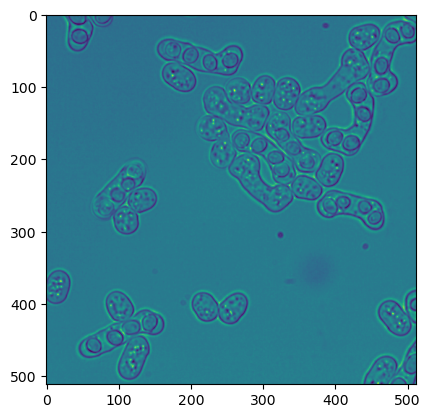

In [22]:
plt.imshow(frame_rgb)

In [25]:
output.keys()

dict_keys(['semantic_logits', 'center_heatmap', 'offset_map', 'semantic_probs', 'panoptic_pred', 'semantic_pred', 'instance_pred', 'instance_center_pred', 'instance_scores'])

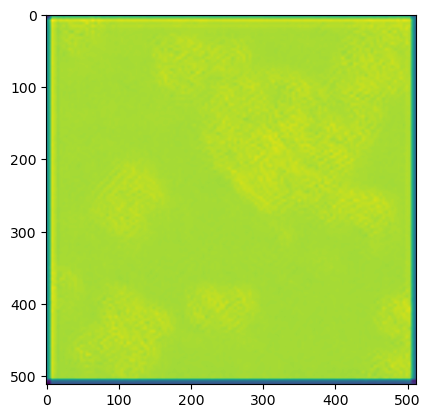

In [32]:
plt.imshow(output['center_heatmap'][0])

In [7]:
_convert_dataset("../../data/set6/", "val", "../tf/val/", True)

9
../../data/set6/images/val/val/3306_2040x2040_bin1x1_zStack_02_07_R3D.png
14073
max: 14073
../../data/set6/images/val/val/IBC180_004.png
13234
max: 13234
../../data/set6/images/val/val/IBC180_026.png
12002
max: 12002
../../data/set6/images/val/val/OD301_01.png
7116
max: 7116
../../data/set6/images/val/val/OD301_03.png
10489
max: 10489
../../data/set6/images/val/val/Replica2_YSM1396WT_04_R3D.png
13403
max: 13403
../../data/set6/images/val/val/Replica3_AV442pak2D_03_R3D.png
13015
max: 13015
../../data/set6/images/val/val/YSM1396_WT_24h_02_R3D.png
21209
max: 21209
../../data/set6/images/val/val/YSM1396_WT_24h_03_R3D.png
22285
max: 22285


In [29]:
from skimage.io import imsave
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage.io import imread
import common

/work/FAC/FBM/DMF/smartin/cellfusion/wanlan/miniconda3/envs/tf210/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
autoaugment_policy.convert_policy(autoaugment_policy.simple_classification_policy)

[[('Sharpness', 0.2, 1), ('Equalize', 0.2, 7)]]

In [26]:
celldataset = runner_utils.create_dataset(configs.train_dataset_options,
    is_training=True,                      
    only_semantic_annotations=False)

00000 (None, None, 1)
1111 (None, None, 1)
2222 (256, 256, 1)
33333 (256, 256, 1)


In [27]:
testdataset = runner_utils.create_dataset(configs.eval_dataset_options,
    is_training=False,                      
    only_semantic_annotations=False)

In [51]:
for example in tfds.as_numpy(celldataset.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    #gt = example["panoptic_gt"]
    #ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape,image.max(),image.min())

['image', 'image_name', 'height', 'width', 'label']
(1, 512, 512, 1) 18637 3397


In [30]:
for example in tfds.as_numpy(testdataset.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    #gt = example["panoptic_gt"]
    #ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape,image.max(),image.min())

['image', 'semantic_gt', 'semantic_loss_weight', 'is_crowd_gt', 'panoptic_gt', 'center_loss_weight', 'regression_loss_weight', 'instance_center_gt', 'instance_regression_gt', 'resized_image', 'image_name', 'size_raw', 'semantic_raw', 'panoptic_raw', 'is_crowd_raw']
(1, 256, 256, 1) 16617.713 3668.166


18637 3397


IndexError: index 1 is out of bounds for axis 0 with size 1

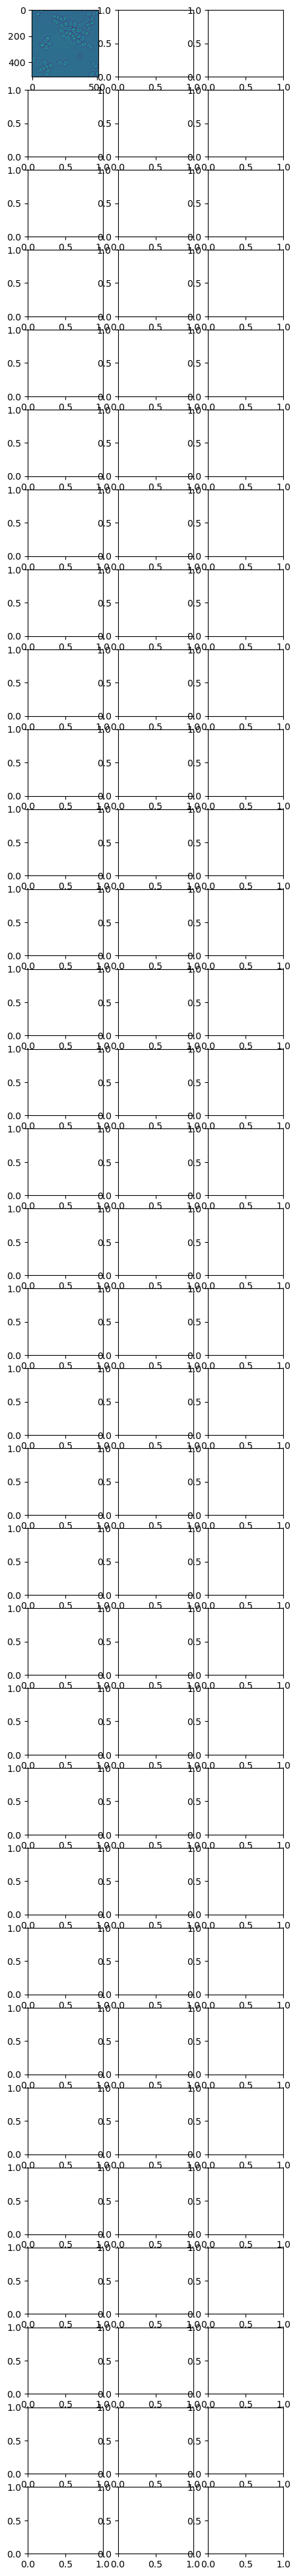

In [53]:
fig,axs = plt.subplots(32, 3, figsize=(5,50))
for i in range(0,32):
    axs[i,0].imshow(image[i,:,:,0])
    #axs[i,1].imshow(gt[i,:,:])
    #axs[i,2].imshow(ct[i,:,:])
    print(image[i,:,:,0].max(),image[i,:,:,0].min())

In [318]:
img = image[1,:,:,0:1]
scale = 0.3
image_shape = tf.shape(img)
new_dim = tf.cast(
  tf.cast([image_shape[0], image_shape[1]], tf.float32) * scale,
  tf.int32)

# Need squeeze and expand_dims because image interpolation takes
# 4D tensors as input.
img = tf.squeeze(
  tf.compat.v1.image.resize_bilinear(
      tf.expand_dims(img, 0), new_dim, align_corners=True), [0])

In [343]:
dataset = tf.data.Dataset.list_files(
    configs.train_dataset_options.file_pattern, shuffle=False)
dataset = dataset.take(1)
dataset = dataset.interleave(
    map_func=tf.data.TFRecordDataset,
    cycle_length=(_NUM_INPUTS_PROCESSED_CONCURRENTLY
                  if False else 1),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    deterministic=not False)

In [255]:
max_value = 65535
def scale_channel(im, c):
    """Scale the data in the channel to implement equalize."""
    im = tf.cast(im[:, :, c], tf.int32)
    # Compute the histogram of the image channel.
    histo = tf.histogram_fixed_width(im, [0, max_value], nbins=(max_value+1))

    # For the purposes of computing the step, filter out the nonzeros.
    nonzero = tf.where(tf.not_equal(histo, 0))
    nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
    step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // max_value#255
    def build_lut(histo, step):
      # Compute the cumulative sum, shifting by step // 2
      # and then normalization by step.
      lut = (tf.cumsum(histo) + (step // 2)) // step
      # Shift lut, prepending with 0.
      lut = tf.concat([[0], lut[:-1]], 0)
      # Clip the counts to be in range.  This is done
      # in the C code for image.point.
      return tf.clip_by_value(lut, 0, max_value)

    # If step is zero, return the original image.  Otherwise, build
    # lut from the full histogram and step and then index from it.
    result = tf.cond(tf.equal(step, 0),
                     lambda: im,
                     lambda: tf.gather(build_lut(histo, step), im))
    tf.cast(result, tf.float32)
    result = result/max_value
    return result

In [259]:
im = image[0,:,:,:]
c = 0
im = tf.cast(im[:, :, c]*65535, tf.int32)
# Compute the histogram of the image channel.
histo = tf.histogram_fixed_width(im, [0, 65535], nbins=65536)

# For the purposes of computing the step, filter out the nonzeros.
nonzero = tf.where(tf.not_equal(histo, 0))
nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 65535

def build_lut(histo, step):
  # Compute the cumulative sum, shifting by step // 2
  # and then normalization by step.
    lut = (tf.cumsum(histo) + (step // 2)) // step
  # Shift lut, prepending with 0.
    lut = tf.concat([[0], lut[:-1]], 0)
  # Clip the counts to be in range.  This is done
  # in the C code for image.point.
    return tf.clip_by_value(lut, 0, 65535)

# If step is zero, return the original image.  Otherwise, build
# lut from the full histogram and step and then index from it.
result = tf.cond(tf.equal(step, 0),
                 lambda: im,
                 lambda: tf.gather(build_lut(histo, step), im))
result = result/65535

In [117]:
_NUM_INPUTS_PROCESSED_CONCURRENTLY = 32
_SHUFFLE_BUFFER_SIZE = 1000
class InputReader(object):
  """Input function that creates a dataset from files."""

  def __init__(self,
               file_pattern,
               decoder_fn,
               generator_fn=None,
               is_training=False):
    """Initializes the input reader.

    Args:
      file_pattern: The file pattern for the data example, in TFRecord format
      decoder_fn: A callable that takes a serialized tf.Example and produces
        parsed (and potentially processed / augmented) tensors.
      generator_fn: An optional `callable` that takes the decoded raw tensors
        dict and generates a ground-truth dictionary that can be consumed by
        the model. It will be executed after decoder_fn (default: None).
      is_training: If this dataset is used for training or not (default: False).
    """
    self._file_pattern = file_pattern
    self._is_training = is_training
    self._decoder_fn = decoder_fn
    self._generator_fn = generator_fn

  def __call__(self, batch_size=1, max_num_examples=-1):
    """Provides tf.data.Dataset object.

    Args:
      batch_size: Expected batch size input data.
      max_num_examples: Positive integer or -1. If positive, the returned
        dataset will only take (at most) this number of examples and raise
        tf.errors.OutOfRangeError after that (default: -1).

    Returns:
      tf.data.Dataset object.
    """
    dataset = tf.data.Dataset.list_files(
        self._file_pattern, shuffle=self._is_training)

    if self._is_training:
      # File level shuffle.
      dataset = dataset.shuffle(dataset.cardinality(),
                                reshuffle_each_iteration=True)
      dataset = dataset.repeat()

    # During training, interleave TFRecord conversion for maximum efficiency.
    # During evaluation, read input in consecutive order for tasks requiring
    # such behavior.
    dataset = dataset.interleave(
        map_func=tf.data.TFRecordDataset,
        cycle_length=(_NUM_INPUTS_PROCESSED_CONCURRENTLY
                      if self._is_training else 1),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
        deterministic=not self._is_training)

    if self._is_training:
      dataset = dataset.shuffle(_SHUFFLE_BUFFER_SIZE)
    if max_num_examples > 0:
      dataset = dataset.take(max_num_examples)

    # Parses the fetched records to input tensors for model function.
    dataset = dataset.map(
        self._decoder_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if self._generator_fn is not None:
      dataset = dataset.map(
          self._generator_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [128]:
decoder = data_utils.SegmentationDecoder(
  is_panoptic_dataset=True,
  decode_groundtruth_label=configs.train_dataset_options.decode_groundtruth_label)
reader = InputReader(
  file_pattern=configs.train_dataset_options.file_pattern,
  decoder_fn=decoder,
  generator_fn=None,
  is_training=True,)

In [129]:
reader = reader(configs.train_dataset_options.batch_size)

In [131]:
for example in tfds.as_numpy(reader.take(10)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    # print(list(example.keys()))
    image = example["image"]
    #gt = example["panoptic_gt"]
    #ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape, np.max(image))#.max(),image.min(), gt.shape)

(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30275425
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30275425
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30275425
(32, 512, 512, 1) 0.30275425
